In [1]:
pip install earthengine-api opencv-python numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install geopy

Defaulting to user installation because normal site-packages is not writeable


In [4]:
pip install earthengine-api requests Pillow matplotlib geopy


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


lake name eg:Chilika Lake  chilika
Start Date- YYYY-MM-DD 2024-01-01
End date-YYYY-MM-DD 2024-01-10
Enter the recipient email for notification:  akshatapandit11@gmail.com


Coordinates for chilika: [85.05036968762617, 19.585320699999997, 85.45036968762618, 19.7853207]


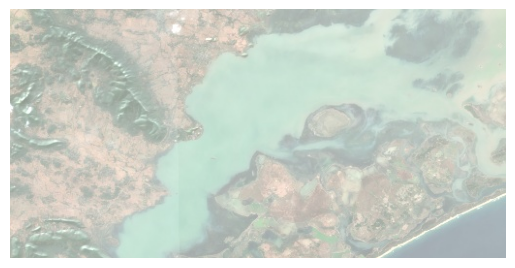

Image URL: https://earthengine.googleapis.com/v1/projects/ee-zdatathon/thumbnails/53afc0380e5af55a817c7a35ad675c06-89473d9c77c688de3bd6066632e37bcd:getPixels


In [13]:
import ee
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
import smtplib
from email.mime.text import MIMEText


def fetch_and_save_copernicus_image(lake_name, start_date, end_date, output_file="output_image.jpg"):
    
    # Initialize Earth Engine API
    ee.Authenticate()  # Make sure you have the necessary authentication for Earth Engine
    ee.Initialize(project='ee-zdatathon')  # Replace 'your-project-id' with your actual project ID

    # Get lake coordinates using geopy
    geolocator = Nominatim(user_agent="lake_image_fetcher")
    location = geolocator.geocode(lake_name)

    if location:
        lake_coordinates = [location.longitude - 0.2, location.latitude - 0.1,  # Adjust bounding box as needed
                            location.longitude + 0.2, location.latitude + 0.1]
        print(f"Coordinates for {lake_name}: {lake_coordinates}")
    else:
        print(f"Could not find coordinates for {lake_name}.")
        return None, None

    # Define the area of interest as a geometry
    geometry = ee.Geometry.Rectangle(lake_coordinates)

    # Fetch the Copernicus Sentinel-2 image collection
    image_collection = (ee.ImageCollection('COPERNICUS/S2_SR')  # Use Sentinel-2 Surface Reflectance
                        .filterDate(start_date, end_date)
                        .filterBounds(geometry)
                        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))  # Filter by cloud cover
                       )

    # Select the least cloudy image, handling potential empty collections
    image = image_collection.median()

    # Check if the image collection is empty
    if image.bandNames().size().getInfo() == 0:
        print("No images found for the specified criteria. Returning None.")
        return None, None  # Or raise an exception if you prefer

    # Select RGB bands (B4, B3, B2 for Sentinel-2)
    image_rgb = image.select(['B4', 'B3', 'B2'])

    # Set visualization parameters, including the region for the thumbnail
    vis_params = {
        'min': 0,
        'max': 3000,  # Adjust this based on the reflectance values
        'gamma': 1.4,
        'region': geometry.bounds().getInfo()['coordinates'],  # Specify the region for the thumbnail
        'dimensions': 512  # Optional: Set the thumbnail dimensions
    }

    # Get the image URL
    url = image_rgb.getThumbURL(vis_params)

    # Fetch the image and save it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    img.save(output_file)

    return img, url  # Return the image and its URL


# Define the inputs
lake_name =input( "lake name eg:Chilika Lake ") # Lake name
start_date =input("Start Date- YYYY-MM-DD")
end_date = input  ( "End date-YYYY-MM-DD")
recipient_email = input("Enter the recipient email for notification: ")

# Fetch and save the Copernicus image of the specified lake
output_image, image_url = fetch_and_save_copernicus_image(lake_name, start_date, end_date, output_file="chilika_lake_copernicus.jpg")

# Store the image address in a variable
image_address = "chilika_lake_copernicus.jpg"  # Path where the image is saved

# Display the image, handling potential None return value
if output_image:
    plt.imshow(output_image)
    plt.axis('off')  # Turn off axis
    plt.show()
    print(f"Image URL: {image_url}")  # Print the image URL for reference

else:
    print("No image to display.")


In [14]:
import cv2
import numpy as np

def process_lake_image(image_path, scaling_factor=1, resolution=(8192, 4190)):
    """Processes a single image to reduce noise, segment the lake, and calculate properties."""

    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Could not load image: {image_path}")
        return

    # Apply median filtering to reduce noise
    filtered_image = cv2.medianBlur(image, ksize=5)

    # Automatic Canny edge detection
    v = np.median(filtered_image)
    sigma = 0.33
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edges = cv2.Canny(filtered_image, lower, upper)

    # Segment the lake
    _, binary_image = cv2.threshold(edges, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assume the largest contour is the lake
    lake_contour = max(contours, key=cv2.contourArea)

    # Calculate properties in pixels
    perimeter_pixels = cv2.arcLength(lake_contour, True)
    area_pixels = cv2.contourArea(lake_contour)

    # Calculate spatial resolution in meters per pixel
    spatial_resolution = (scaling_factor / 1000000) * (resolution[0] / 8192)
    perimeter_meters = perimeter_pixels * spatial_resolution
    area_sq_km = area_pixels * (spatial_resolution * 2000)


    # Print the results
    print(f"Image: {image_path}")
    print(f"Area: {area_sq_km:.2f} sq km")


# Example usagejpg
process_lake_image(image_address)

Image: chilika_lake_copernicus.jpg
Area: 0.01 sq km


In [15]:
import cv2
import numpy as np
import smtplib
from email.mime.text import MIMEText

def process_lake_image(image_path, scaling_factor=1, resolution=(8192, 4190)):
    """Processes a single image to reduce noise, segment the lake, and calculate the area."""

    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Could not load image: {image_path}")
        return None

    # Apply median filtering to reduce noise
    filtered_image = cv2.medianBlur(image, ksize=5)

    # Automatic Canny edge detection
    v = np.median(filtered_image)
    sigma = 0.33
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edges = cv2.Canny(filtered_image, lower, upper)

    # Segment the lake
    _, binary_image = cv2.threshold(edges, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assume the largest contour is the lake
    lake_contour = max(contours, key=cv2.contourArea)

    # Calculate properties in pixels
    area_pixels = cv2.contourArea(lake_contour)

    # Calculate spatial resolution in meters per pixel
    spatial_resolution = (scaling_factor / 1000000) * (resolution[0] / 8192)
    area_sq_meters = area_pixels * (spatial_resolution * 2000)

    # Print the results
    print(f"Image: {image_path}")
    print(f"Area: {area_sq_meters:.2f} square meters")

    return area_sq_meters

def calculate_threshold(area_sq_meters):
    """Automatically sets the area threshold based on lake size."""

    if area_sq_meters > 5_000_000:  # Large lake > 5 sq km
        threshold_percentage = 5  # 5% reduction for large lakes
    elif 1_000_000 <= area_sq_meters <= 5_000_000:  # Medium lake between 1 and 5 sq km
        threshold_percentage = 10  # 10% reduction for medium lakes
    else:  # Small lake < 1 sq km
        threshold_percentage = 15  # 15% reduction for small lakes

    threshold_value = area_sq_meters * (threshold_percentage / 100)
    print(f"Calculated Threshold: {threshold_value:.2f} square meters (Reduction of {threshold_percentage}%)")
    return threshold_value

def send_email_alert(current_area, threshold, recipient_email):
    """Sends an email alert if the lake area is below the threshold."""

    sender_email = "zdatathon@gmail.com"
    sender_password = "xkgm tnka jmih iemq"

    # Create the email message
    subject = "Lake Encroachment Alert: Lake Area Below Threshold"
    body = f"Warning! The lake area has been calculated as {current_area:.2f} sq meters, which is below the threshold of {threshold:.2f} sq meters."

    msg = MIMEText(body)
    msg['Subject'] = subject
    msg['From'] = sender_email
    msg['To'] = recipient_email

    try:
        # Connect to the Gmail SMTP server
        with smtplib.SMTP('smtp.gmail.com', 587) as server:
            server.starttls()  # Secure the connection
            server.login(sender_email, sender_password)
            server.sendmail(sender_email, recipient_email, msg.as_string())
        print("Email alert sent successfully!")

    except Exception as e:
        print(f"Failed to send email alert: {e}")

def monitor_lake(image_path, recipient_email):
    """Monitors the lake by processing the image, calculating area, and sending alerts if needed."""

    # Process the lake image to calculate the lake area
    current_area = process_lake_image(image_path)

    if current_area is None:
        print("Error processing the lake image.")
        return

    # Calculate the area threshold based on the lake size
    threshold = calculate_threshold(current_area)

    # Check if the current area is below the threshold
    if current_area > threshold:
        print(f"Alert: Lake area is below the threshold Lake is in danger.")
        send_email_alert(current_area, threshold, recipient_email)
    else:
        print(f"Lake area is above the threshold. No alert triggered.")

# Example usage
#jpg_path = image_address  # Provide the path to your lake image
#recipientemail =recipient_email  # The recipient email for the alert

monitor_lake(image_address,recipient_email  )


Image: chilika_lake_copernicus.jpg
Area: 0.01 square meters
Calculated Threshold: 0.00 square meters (Reduction of 15%)
Alert: Lake area is below the threshold Lake is in danger.
Email alert sent successfully!
